## As our data depends on time, we are going to analyze it as a Time Series.

### Import libraries

In [1]:
import pandas as pd
import itertools
import statsmodels.api as sm
from pylab import rcParams

#To plot
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
cf.go_offline()

### Import and check the data

In [47]:
data = pd.read_csv('../Data/Oni_region_label.csv')
data['date'] = pd.to_datetime(data['date'])

In [48]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
0,5796,1983,10,30,1983-10-30,-0.04,-124.54,-1.9,0.9,NaN,21.56,NaN,0
1,5797,1983,10,31,1983-10-31,-0.04,-124.54,-1.5,1.0,NaN,21.56,NaN,0
2,5798,1983,11,1,1983-11-01,-0.04,-124.54,-1.9,-0.1,NaN,21.64,NaN,0
3,5799,1983,11,2,1983-11-02,-0.04,-124.54,-0.9,-0.4,NaN,22.01,NaN,0
4,5800,1983,11,3,1983-11-03,-0.04,-124.54,-1.6,0.8,NaN,22.21,NaN,0


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50608 entries, 0 to 50607
Data columns (total 13 columns):
obs           50608 non-null int64
year          50608 non-null int64
month         50608 non-null int64
day           50608 non-null int64
date          50608 non-null datetime64[ns]
latitude      50608 non-null float64
longitude     50608 non-null float64
zon.winds     47076 non-null float64
mer.winds     47076 non-null float64
humidity      32796 non-null float64
air temp.     46950 non-null float64
s.s.temp.     46188 non-null float64
buoy_label    50608 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 5.0 MB


In [50]:
data.isnull().sum()

obs               0
year              0
month             0
day               0
date              0
latitude          0
longitude         0
zon.winds      3532
mer.winds      3532
humidity      17812
air temp.      3658
s.s.temp.      4420
buoy_label        0
dtype: int64

### Plot the data to see a first glimpse

In [51]:
g = data.groupby(by='date').mean()

In [52]:
g.shape

(5368, 12)

In [53]:
g.isnull().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds        0
mer.winds        0
humidity      2337
air temp.        1
s.s.temp.      212
buoy_label       0
dtype: int64

In [54]:
g['s.s.temp.'].rolling(window= 30).mean().iplot(kind='line', xTitle='Date',
           yTitle='Sea Surface Temperature (ºC))', title='Sea Surface Temperature between 1984 and  1998')

### Clean and take the data for the analysis

#### We group our data by months and check nan values.

In [55]:
y = data.groupby(by='date').mean().resample('MS').mean()['s.s.temp.']
y.isnull().sum()

10

#### If, we then only take values from April 1984, can avoid some nan values that are present in the data set. 

In [56]:
y[y.index > '1984-4-01'].isnull().sum()

2

#### I fill the 2 nan values of 1987-03-01 and 1987-04-01 with the intermediate values of 27.720290 and 28.092553.


In [57]:
y['1987-03-01'] = 27.720290
y['1987-04-01'] = 28.092553

#### If, we then only take values from April 1984, we skip all nan values related to sea surface temperature. 

In [58]:
y[(y.index > '1984-04-01')].isnull().sum()

0

In [59]:
y_rev = y[y.index > '1984-4-01']

#### Finally, we plot the cleaned and ready-to-analyze data

In [60]:
y_rev.iplot(kind='line', xTitle='Time',
           yTitle='Sea Temperature (ºC)', title='Sea surface temperature between 1984 and  1998')

## Decomposition Analysis

#### Decompose the time-series into three distinct components: trend, seasonality and noise

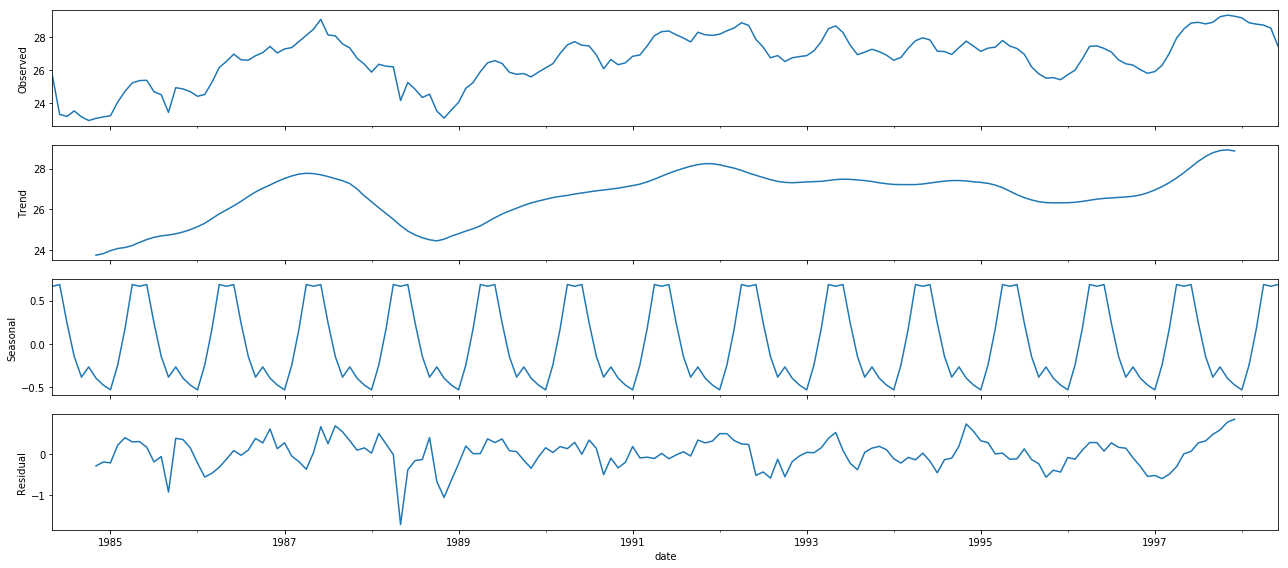

In [61]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='additive')
fig = decomposition.plot()
plt.show()

## SARIMAX method

Autoregressive Integrated Moving Average, or ARIMA is a well established method for Time Series Analysis. However, it does not support seasonal data. As our data has seasonal components, we will use seasonal ARIMA or SARIMA instead. 

Moreover, ARIMA and SARIMA are only valid to stationary data. As the meteorological data we have tends to repeat over years (we will discard any climate change effect), we can considered it stationary. 

 Therefore, in order to analyze and forecast the meridional winds vs Time, we use the SARIMAX method.
The additional X means that the method is able to manage exogenous variables (variables that are not affected by others variables in the method). However, in this analysis we are not going to use them.

First, we need to find the most optimal SARIMAX parameters that fits with our data. To do so, we generate a combination of parameters that will be evaluated with our data. 

In [62]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets. As our data is structured in months, we set a 12 as the periodicity. 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [63]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [64]:
# Two for loops in order to try pdq and seasonal pdq parameters.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_rev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1591.7393014893541
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1311.3140889269475
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:594.7563594577798
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:539.2408447246885
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:592.5297251081656
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:543.8871268675906
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:555.9299905361547
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:511.34929672014164
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1360.1787592009564


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1307.295395898927
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:448.87644767903834
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:389.66386053460775
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:454.8270879797209
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:396.3290388258564
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:415.2547700819152
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:375.6724421547275
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:222.00362596282787
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:201.37231997009883
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:263.37023871845287
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:170.83149947622178
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:200.06314157031304


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:197.66921205710628
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:217.5778855328063
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:183.9540752104776
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:218.09630441130548
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:198.26959114958515
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:263.17849628131387
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:168.7698341596547
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:200.1606855590851
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:185.34393144042804
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:218.62029983459252
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:184.9145447930718
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:247.56862948256725
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:203.68766169272578
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:277.7043180546941
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:180.07663815702523
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:202.0579903786139
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:204.0455740365728
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:216.0269718186514
A

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:185.87874978693947
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:217.3044542444058
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:196.6088244340819
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:262.6527638579865
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:170.39901612247232
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:199.04837114749517
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:187.2907969902825
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:208.19126983933813
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:172.39925362199222


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Thus, the parameters that are related to our most optimal fit are:

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:164.49379462358243

#### Fitting the SARIMAX model with the previously found values. 

In [65]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_rev,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarimax_model.fit()

# We plot the result summary
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                          s.s.temp.   No. Observations:                  170
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -78.247
Date:                            Tue, 23 Apr 2019   AIC                            164.494
Time:                                    17:18:44   BIC                            176.373
Sample:                                05-01-1984   HQIC                           169.321
                                     - 06-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9439      0.025     37.868      0.000       0.895       0.993
ma.L1          0.0417      0.077   

# If we have a P > z, we need to reject that this coeficient is important for the analysis, isnt it? how do we remove it?

#### In order to visualize check the fitness of our model, we plot the diagnostics graphs.

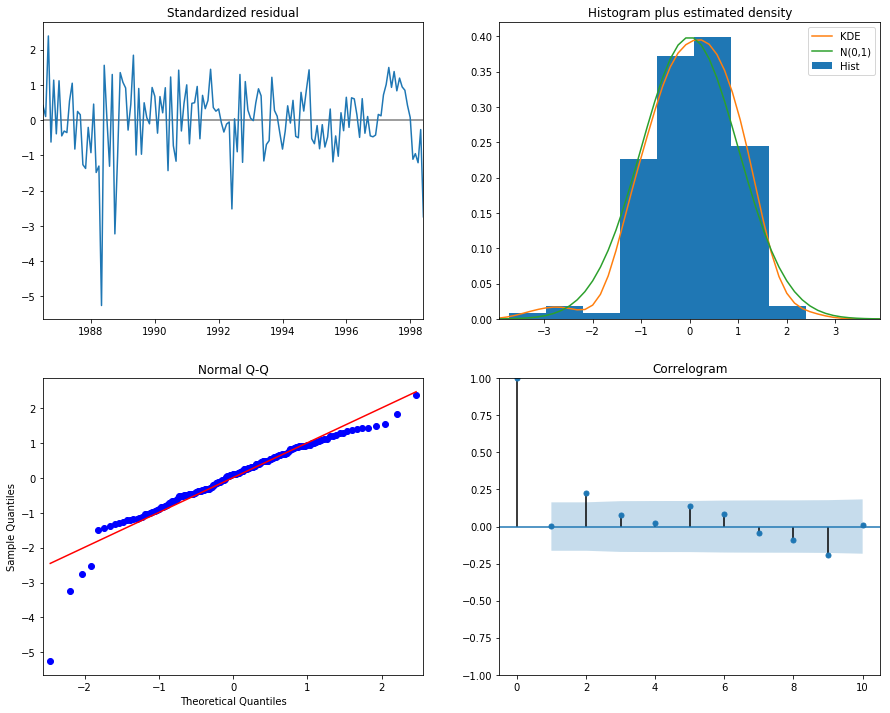

In [66]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), except for the first section of the regression. Again, this is an indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Model prediction. 
#### We predict the meridional winds of the last years of data. 

In [67]:
pred = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

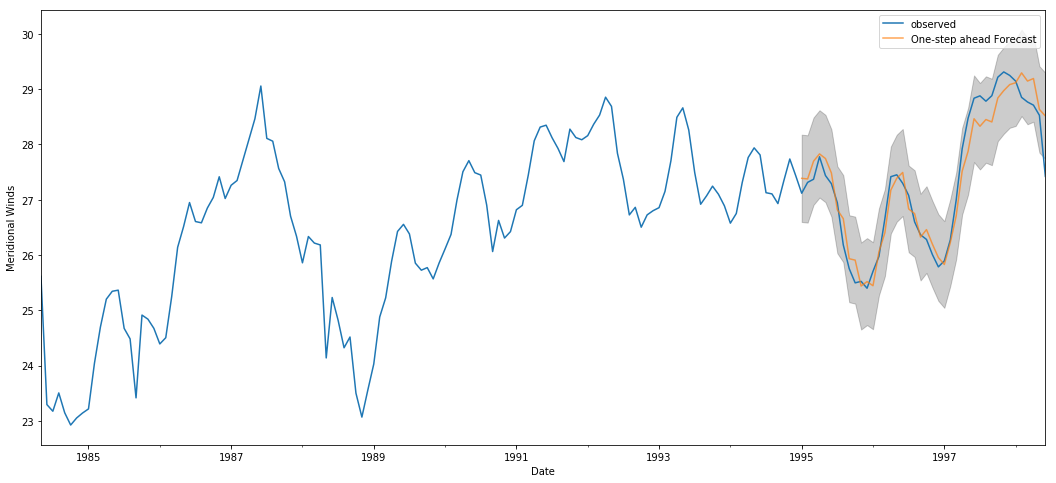

In [68]:
ax = y_rev['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Meridional Winds')
plt.legend()


plt.show()


#### Model accuracy. 
We will use the MSE (Mean Squared Error) which summarize the average error of our forecasts. 

In [69]:
y_forecasted = pred.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.11


However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

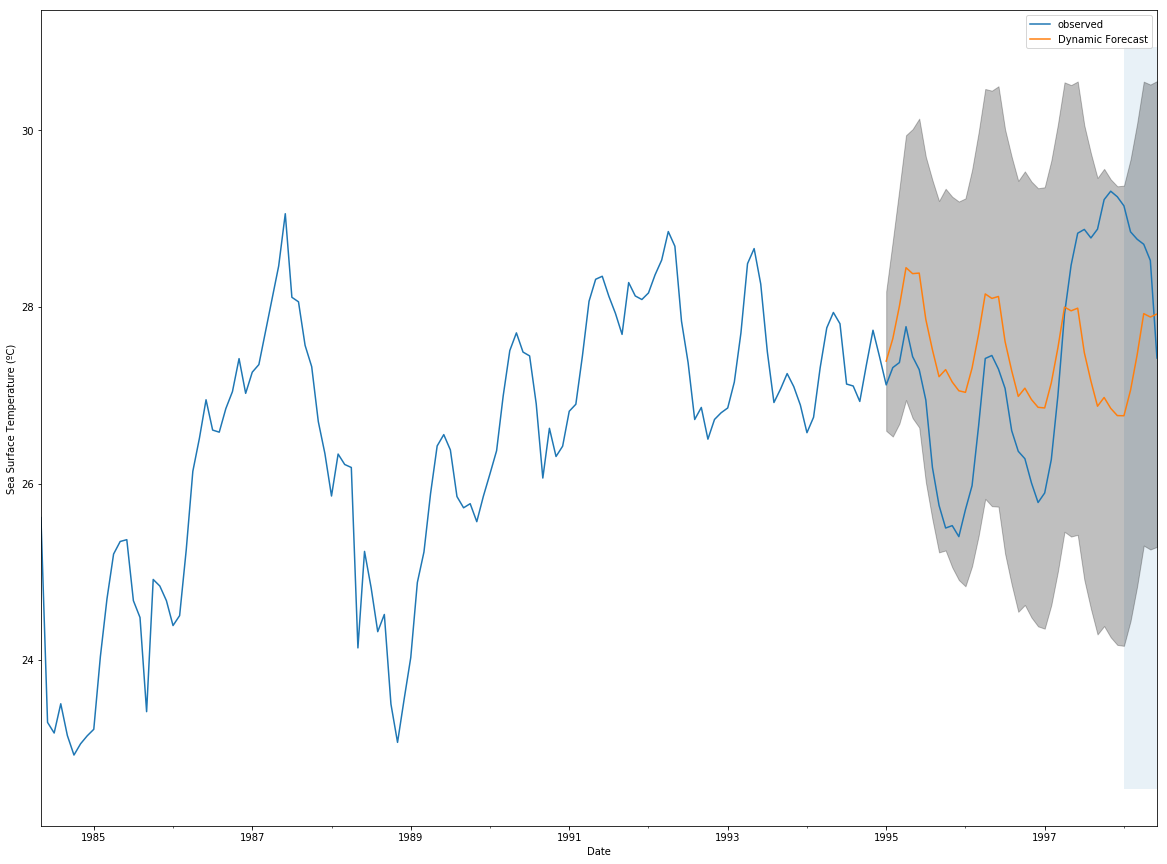

In [71]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1998-01-01'),
                 y_rev.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperature (ºC)')

plt.legend()
plt.show()

In [72]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.6


The MSE is higher than before. This is expected as we are dynamic forecast relies less on historical data. 

### Forecasting the model

#### Finally, we forecast our model predicting 100 months ahead. 

In [73]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



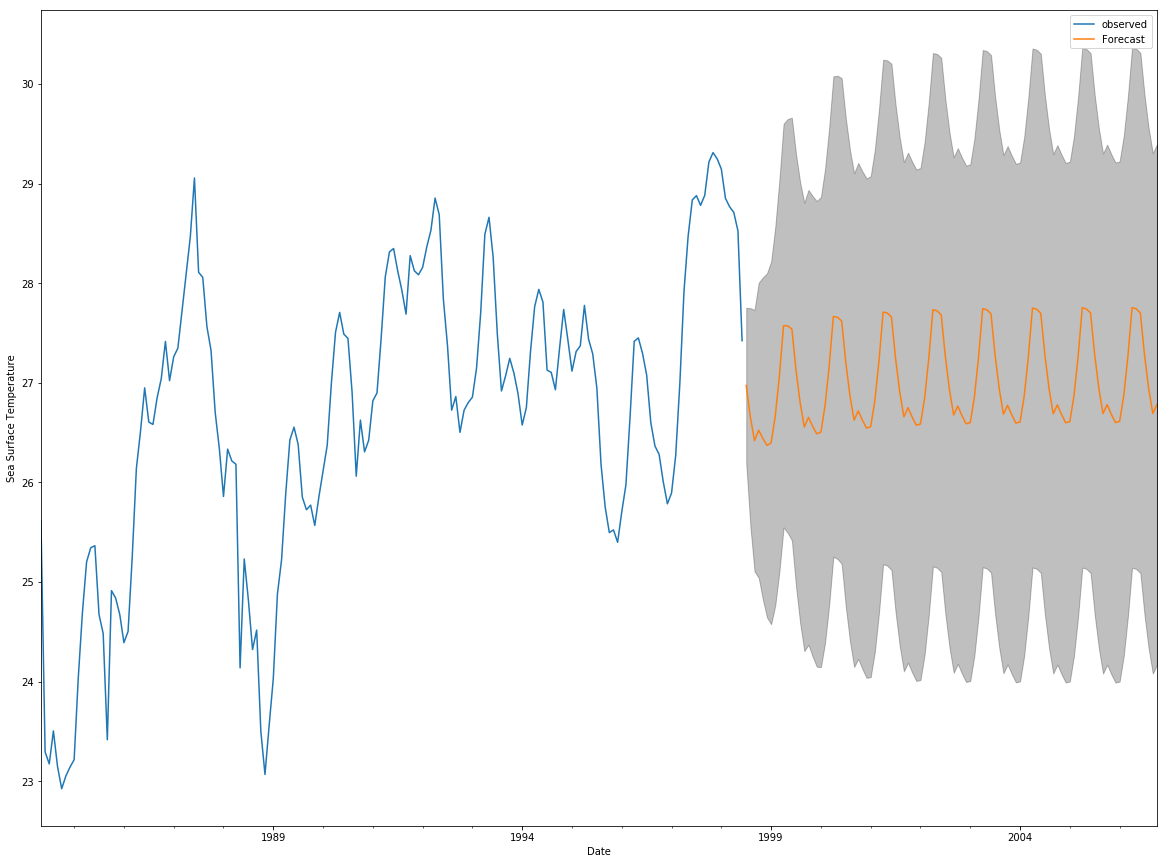

In [74]:
ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperature')

plt.legend()
plt.show()


# Try to understand this.

### Compare el niño vs normal periods

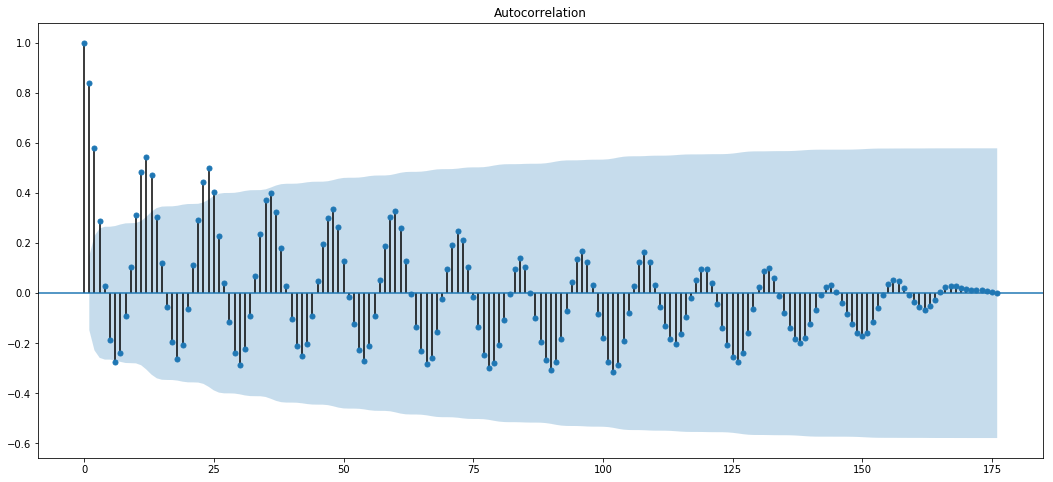

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_rev)
plt.show()

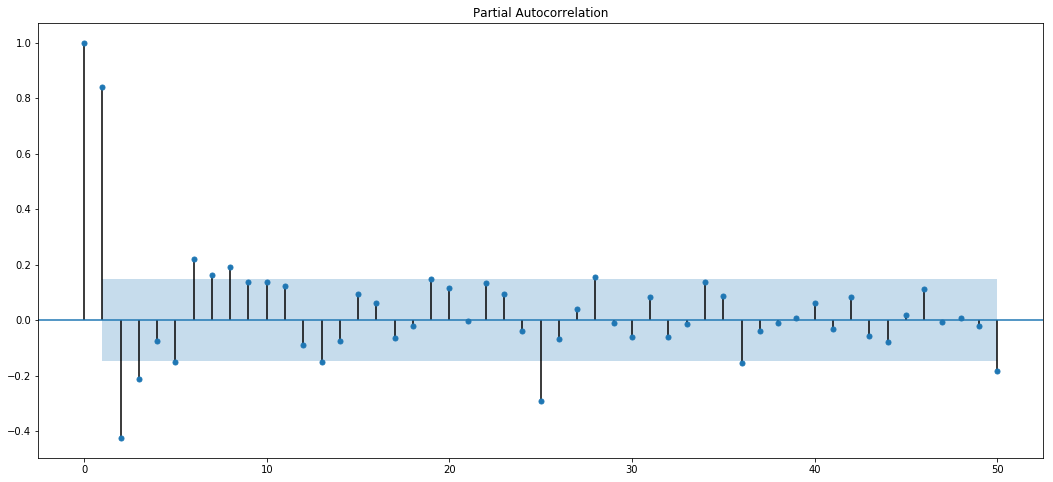

In [84]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_rev, lags=50)
plt.show()